In [1]:
import osmnx as ox
# import osm2gmns as og
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import CRS
import contextily as ctx
# from dotmotif import Motif, GrandIsoExecutor
from shapely import speedups
import numpy as np
import xml.etree.ElementTree as ET
import glob
import multiprocessing
import time

## Data preprocessing

### KowLong street graph from OSM

In [2]:
def load_from_osm(place_name="Kowloon, Hong Kong, China"):

    # Get the area of interest polygon
    place_polygon = ox.geocode_to_gdf(place_name)
    # Re-project the polygon back to WGS84, as required by osmnx
    place_polygon = place_polygon.to_crs(epsg=4326)
    # Retrieve the network
    graph = ox.graph_from_polygon(place_polygon["geometry"].values[0], network_type='drive', custom_filter='["highway"~"primary|secondary|trunk"]')

    # Project the data to UTM, since ox.consolidate_intersections need this CRS to compute disntance, WGS84 is not for distance computation
    graph_proj = ox.project_graph(graph, 'EPSG:32649')
    #
    graph_proj = ox.consolidate_intersections(graph_proj, tolerance=50)
    # re-project the graph back to WGS84 for visualization in longitude and latitude format
    graph_proj = ox.project_graph(graph_proj, "EPSG:4326")
    #
    graph_proj = graph_proj.to_undirected()
    # Get Edges and Nodes
    nodes_proj, edges_proj = ox.graph_to_gdfs(ox.get_undirected(graph_proj), nodes=True, edges=True)
    # ox.save_graph_xml(graph, './data/kowlong.osm')
    return nodes_proj, edges_proj, place_polygon, graph_proj
    
nodes_proj, edges_proj, place_polygon, graph_proj = load_from_osm("Kowloon, Hong Kong, China")

### KowLong sensor points

In [3]:
def load_sensor_data(file_path = './dataset/traffic_speed_volume_occ_info.csv'):
    raw_sensors = pd.read_csv(file_path)
    raw_sensors_gpd = gpd.GeoDataFrame(raw_sensors, geometry=gpd.points_from_xy(raw_sensors.Longitude, raw_sensors.Latitude), crs = "EPSG:4326")
    # enable spatial query speed up
    speedups.enabled
    sensor_mask = raw_sensors_gpd.within(place_polygon.loc[0, 'geometry'])
    sensors_gpd = raw_sensors_gpd[sensor_mask]

    return sensors_gpd

sensors_gpd = load_sensor_data()

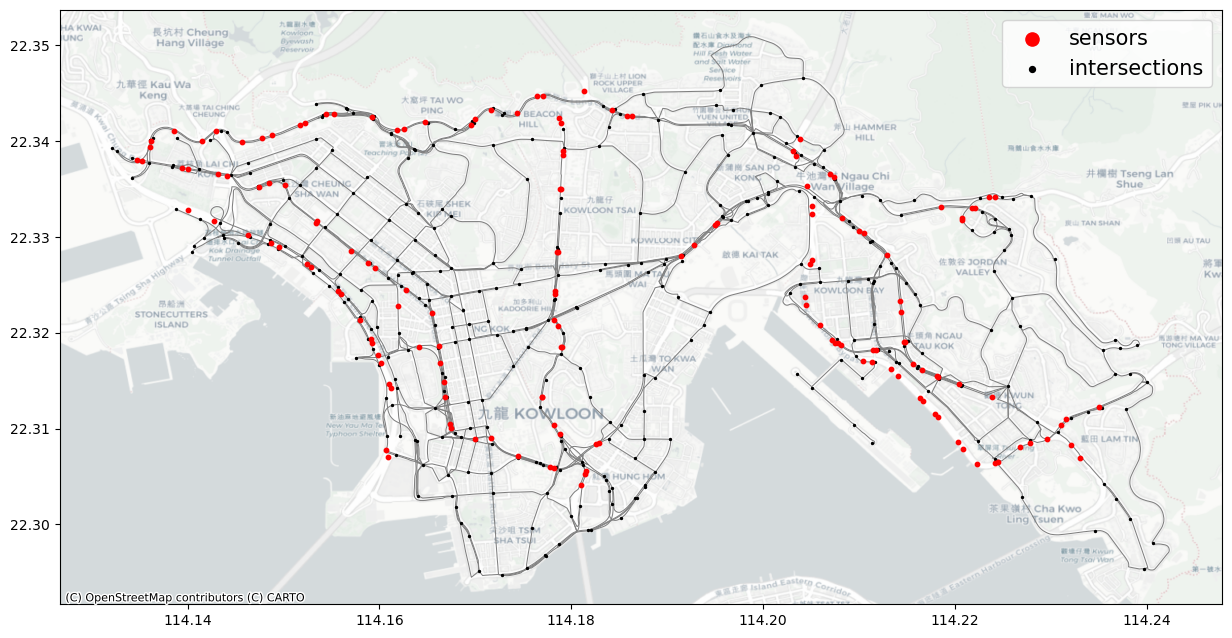

In [4]:
# plot the graph:
fig, ax = plt.subplots(figsize=(15,15))
# Plot edges and nodes
sensors_gpd.plot(ax=ax, markersize=10, color='red',label='sensors', zorder=3)
nodes_proj.plot(ax=ax, markersize=2, color='black', label='intersections',zorder=2)
edges_proj.plot(ax=ax, linewidth=0.75, color='gray', zorder=1)

ax.legend(markerscale=3, prop={'size': 15})
# minx, miny, maxx, maxy = place_polygon.bounds.values[0]
# ax.set_xlim(minx, maxx)
# ax.set_ylim(miny, maxy)
# Add the origin and destination nodes of the route
# ax = motif_nodes.plot(ax=ax, markersize=3, color='red')
# Add basemap

ctx.add_basemap(ax, crs=nodes_proj.crs, source=ctx.providers.CartoDB.Positron)
fig.savefig('./figs/sensor_street_kowlong.svg')

In [5]:
# print(road segment type))
def unique(list1):
    # intilize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return unique_list

unique(edges_proj.highway.values)

['primary',
 'primary_link',
 'secondary',
 ['secondary_link', 'primary_link'],
 'trunk_link',
 ['primary', 'secondary'],
 ['primary', 'primary_link'],
 ['primary', 'trunk'],
 'trunk',
 ['trunk', 'trunk_link'],
 ['secondary', 'trunk_link'],
 ['primary', 'trunk_link'],
 ['secondary', 'primary_link'],
 'secondary_link',
 ['secondary', 'secondary_link'],
 ['secondary_link', 'secondary'],
 ['primary', 'trunk', 'trunk_link']]

### Concat sensor_gpd and street node gpd, and compute distance matrix

make sure CRS are identical

In [6]:
nodes_proj.crs == sensors_gpd.crs

True

Missing rate: #road_nodes / (#road_nodes + #sensors)

In [7]:
nodes_proj.shape[0] / (nodes_proj.shape[0] + sensors_gpd.shape[0])

0.7012987012987013

re-project from WGS84 to UTM for distance matrix computation

In [8]:
nodes_proj.to_crs(32649,inplace=True)
sensors_gpd.to_crs(32649,inplace=True)
edges_proj.to_crs(32649,inplace=True)

Some detector id cannot match with thoes of speed data

In [9]:
sensors_gpd.AID_ID_Number = sensors_gpd.AID_ID_Number.str.replace(r'/', '')

In [10]:
sensors_gpd.reset_index(drop=True,inplace=True)
sensors_gpd.head(1)

,AID_ID_Number,District,Road_EN,Road_TC,Road_SC,Easting,Northing,Latitude,Longitude,Direction,Rotation,geometry
0,AID01111,Kowloon City,Hong Chong Road near The Hong Kong Polytechnic...,康莊道近香港理工大學 - 北行（1）,康庄道近香港理工大学 - 北行（1）,836693,818352,22.30412,114.180999,East,80,POINT (827761.392 2469944.950)


In [11]:
sensors_id_array = np.unique(sensors_gpd.AID_ID_Number)

concat the two geodataframes

In [12]:
def concat_gpd(nodes_proj, sensors_gpd):
    node_cat = nodes_proj[['geometry']].reset_index(drop=True)
    node_cat['type'] = 'intersection'
    sensor_cat = sensors_gpd[['geometry']].reset_index(drop=True)
    sensor_cat['type'] ='sensor'
    node_total = pd.concat([sensor_cat, node_cat]).reset_index(drop=True)
    node_total.head(3)
    
    return node_total

## Kowlong speed data preprocessing

Update sensors_id_array since we need an union of sensor_id in speed data and sensor location data

In [13]:
root_path = './HK_traffic_speed'
day_path = glob.glob(root_path+"./*")

In [14]:
import multi_data
def update_sensor_ls(path, sensors_id_array, sensors_gpd):
    params = [path, sensors_id_array, sensors_gpd, 1]
    speed_df=multi_data.load_speed_data(params)
    # also update sensors_gpd
    
    return np.intersect1d(np.unique(speed_df.detector_id), sensors_id_array)

sensors_id_array = update_sensor_ls(day_path[0], sensors_id_array, sensors_gpd)
sensors_gpd = sensors_gpd[sensors_gpd.AID_ID_Number.isin(sensors_id_array)]
sensors_gpd.reset_index(drop=True, inplace=True)

In [ ]:
params = []
for i in range(len(day_path)):
    params.append([day_path[i], sensors_id_array, sensors_gpd, 0])
cores = multiprocessing.cpu_count() - 1
with multiprocessing.Pool(cores) as pool:
    nd_ls = pool.map(multi_data.load_speed_data, params, chunksize=1)
    pool.close()
    pool.join()

In [ ]:
day_nslot_ls = [each.shape[0] for each in nd_ls]
day_nslot_ls_df = pd.DataFrame(day_nslot_ls)

In [ ]:
# ndarray_1day = pd.DataFrame(np.round(ndarray_1day.astype(np.double),2))
# ndarray_1day.fillna(method="ffill",inplace=True)
df_total = pd.DataFrame(np.concatenate(nd_ls, axis=0))

In [ ]:
day_nslot_ls_df.to_csv('./dataset/kowlong_nslot_ls.csv',header=False, index=False)
df_total.to_csv('./dataset/kowlong_sensor_speed.csv',header=False, index=False)

Compute distance matrix

In [ ]:
node_total = concat_gpd(nodes_proj, sensors_gpd)
node_total.geometry.apply(lambda g: node_total.distance(g)).to_csv('./dataset/kowlong_distance.csv', header=False, index=False)

In [ ]:
node_total.geometry.apply(lambda g: node_total.distance(g)).index

### GIS visualization

In [19]:
pred_mat = pd.read_csv('./dataset/prediction.csv', header=None).values

In [20]:
pred_mat.shape

(532, 450)

#### Concat sensor and street intersections
Notice the crs is not in WGS84 for distance computation purpose

In [22]:
#concat sensor and street intersections, notice the crs is not in WGS84 for distance computation purpose
total_node_gpd = concat_gpd(nodes_proj, sensors_gpd)
node_ls = total_node_gpd['geometry'].values # Point geometry array

# node_ls = node_ls[:154]

# convert to UTM coordinates for distance computation purpose
road_ls = list(edges_proj['geometry'].values)

# init traffic state
edges_proj.reset_index(drop=True, inplace=True)
edges_proj['traffic'] = 0

#### find closet LineString to each node in total_node_gpd

In [23]:
def update_egde_gpd(lines, points, edge_gpd, pred_mat, time_step):
    for i in range(len(points)):
        # print(len(lines))
        point = points[i]
        # get distances
        distance_list = [line.distance(point) for line in lines]

        shortest_distance = min(distance_list) # find two smallest distances

        each_road_idx = distance_list.index(shortest_distance)
        closest_line = lines[each_road_idx]
        edge_gpd.loc[edge_gpd['geometry'] == closest_line, 'traffic'] = pred_mat[:, time_step][i]
        lines.pop(each_road_idx)

In [ ]:
time_step=0
update_egde_gpd(road_ls, node_ls, edges_proj, pred_mat, time_step)

In [ ]:
len(edges_proj[edges_proj['traffic'] > 0])

In [ ]:
# plot the graph:
fig, ax = plt.subplots(figsize=(10,10))
# Plot edges and nodes
# sensors_gpd.plot(ax=ax, markersize=10, color='red',label='sensors', zorder=3)
# nodes_proj.plot(ax=ax, markersize=2, color='black', label='intersections',zorder=2)
sensors_gpd.to_crs(4326).plot(ax=ax, markersize=4, color='black',label='sensors', zorder=3)
nodes_proj.to_crs(4326).plot(ax=ax, markersize=2, color='grey', label='intersections',zorder=2)


vmin = pred_mat.min()
vmax = pred_mat.max()

edges_proj.to_crs(4326,inplace=True)
edges_proj_vis = edges_proj[edges_proj['traffic'] > 0]
# sort in descending order to prevent jammed road segments being overlapped
ax = edges_proj_vis.sort_values(by='traffic', ascending=False).plot(ax=ax, column='traffic', vmin = vmin, vmax=vmax, cmap='RdYlGn', linewidth=2, zorder=1,alpha=0.9)

ax.legend(markerscale=2, prop={'size': 10})
# minx, miny, maxx, maxy = place_polygon.bounds.values[0]
# ax.set_xlim(minx, maxx)
# ax.set_ylim(miny, maxy)
# find max min value of traffic for colorbar plottng
plt.title('Network-wise traffic forecasting with incomplete sensor coverage')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax,label='Vehicle Speed (km/h)')
cbr.ax.tick_params(labelsize=10) 

# Add basemap
# ctx.add_basemap(ax, crs=edges_proj.crs, source=ctx.providers.CartoDB.DarkMatter)
ctx.add_basemap(ax, crs=edges_proj.crs, source=ctx.providers.CartoDB.Positron)

# plt.tight_layout()

fig.savefig('./figs/pred_network_kowlong.svg',transparent=True)
edges_proj.to_crs(32649,inplace=True)

In [19]:
ctx.providers.CartoDB.keys()

dict_keys(['Positron', 'PositronNoLabels', 'PositronOnlyLabels', 'DarkMatter', 'DarkMatterNoLabels', 'DarkMatterOnlyLabels', 'Voyager', 'VoyagerNoLabels', 'VoyagerOnlyLabels', 'VoyagerLabelsUnder'])

In [ ]:
vmin = pred_mat.min()
vmax = pred_mat.max()

for time_step in range(pred_mat.shape[1]):
    #concat sensor and street intersections, notice the crs is not in WGS84 for distance computation purpose
    total_node_gpd = concat_gpd(nodes_proj, sensors_gpd)
    node_ls = total_node_gpd['geometry'].values # Point geometry array

    # node_ls = node_ls[:154]

    # convert to UTM coordinates for distance computation purpose
    road_ls = list(edges_proj['geometry'].values)

    # init traffic state
    edges_proj.reset_index(drop=True, inplace=True)
    edges_proj['traffic'] = 0

    update_egde_gpd(road_ls, node_ls, edges_proj, pred_mat, time_step)
    
    # plot the graph:
    fig, ax = plt.subplots(figsize=(10,10))
    # Plot edges and nodes
    sensors_gpd.to_crs(4326).plot(ax=ax, markersize=4, color='black',label='sensors', zorder=3)
    nodes_proj.to_crs(4326).plot(ax=ax, markersize=2, color='grey', label='intersections',zorder=2)

    edges_proj.to_crs(4326,inplace=True)
    edges_proj_vis = edges_proj[edges_proj['traffic'] > 0]
    # sort in descending order to prevent jammed road segments being overlapped
    ax = edges_proj_vis.sort_values(by='traffic', ascending=False).plot(ax=ax, column='traffic', vmin = vmin, vmax=vmax, cmap='RdYlGn', linewidth=2, zorder=1,alpha=0.9)

    ax.legend(markerscale=2, prop={'size': 10})

    plt.title('Network-wise traffic forecasting with incomplete sensor coverage')
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')

    cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbr = fig.colorbar(sm, cax=cax,label='Vehicle Speed (km/h)')
    cbr.ax.tick_params(labelsize=10) 

    # Add basemap
    # ctx.add_basemap(ax, crs=edges_proj.crs, source=ctx.providers.CartoDB.DarkMatter)
    ctx.add_basemap(ax, crs=edges_proj.crs, source=ctx.providers.CartoDB.Positron)

    # plt.tight_layout()

    fig.savefig('./figs/gif/pred_network_kowlong_{:03d}.png'.format(time_step),dpi=300, transparent=True, bbox_inches='tight')
    edges_proj.to_crs(32649,inplace=True)

In [1]:
%cd figs/gif/

d:\research\ST_GAT_Traffic_Speed_Prediction_with_Partial_Sensor_Network\figs\gif


In [ ]:
!ffmpeg -framerate 2 -i pred_network_kowlong_%03d.png -f gif predict.gif

In [ ]:
!ffmpeg -framerate 3 -i pred_network_kowlong_%03d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" predict.mp4